In [46]:
!pip install gensim


In [47]:
df = pd.read_csv("/Users/fionaaaaa_mei/Downloads/august_2023_searches.csv")
df = df.head(10000)
df.head(5)

,dt,institutional_affiliation,metric_id,personal_account_id,search_type,query_string,requestid,auth_sessionid
0,2023-08-03,False,Searches_Platform_3d33f627-3ad0-4e7e-9832-7390...,c6cefc2a-6d0a-4f3e-9e1e-7bc6b27ac5f9,basic_search,NaN,14c47cd5-9d31-fee3-cfce-76d9b7214ac3,94f1a3263a6348f1bf7ffbd6d8c39c05
1,2023-08-25,True,Searches_Platform_0c60725b-87d3-49ed-bb1b-0b66...,NaN,basic_search,NaN,1525f88f-dcc4-58a7-580a-9e2e2ad06768,818df6122523486181e3619ea694095c
2,2023-08-12,False,Searches_Platform_786def01-bdf1-4d6a-adda-c5c8...,NaN,basic_search,NaN,1b4c0339-e625-133a-ced9-8eaa7fe09695,9f98b93cdd964f5fb54363336fded27a
3,2023-08-31,True,Searches_Platform_b5f671cd-d299-402b-9067-5092...,NaN,basic_search,NaN,1f9fcf72-f889-466f-8ac8-4e0066d55b16,87d139d379264f61b247bab366411388
4,2023-08-25,False,Searches_Platform_35ef3849-f2be-4d8d-8911-3afe...,NaN,basic_search,NaN,2307d346-05b1-c826-6a92-f1732ed22fb2,cf99c55f8014455c8ce8b0301741da7e


In [48]:
#Remove all NaN cases in query_string
df = df.dropna(subset=['query_string'])

#Remove punctuation & split
RE_PATTERN = re.compile("[a-zA-Z]+")
df['query_string']= df['query_string'].str.findall(RE_PATTERN)


#Remove Uppercase letters
df['query_string'] = df['query_string'].apply(lambda x: [item.lower() for item in x])



#Remove stop words and rejoin list of words
#Lifted from https://medium.com/@yashj302/stopwords-nlp-python-4aa57dc492af

stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
              'ourselves', 'you', 'your', 'yours', 'yourself',
              'yourselves', 'he', 'him', 'his', 'himself', 'she',
              'her', 'hers', 'herself', 'it', 'its', 'itself',
              'they', 'them', 'their', 'theirs', 'themselves',
              'what', 'which', 'who', 'whom', 'this', 'that',
              'these', 'those', 'am', 'is', 'are', 'was', 'were',
              'be', 'been', 'being', 'have', 'has', 'had', 'having',
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
              'but', 'if', 'or', 'because', 'as', 'until', 'while',
              'of', 'at', 'by', 'for', 'with', 'about', 'against',
              'between', 'into', 'through', 'during', 'before',
              'after', 'above', 'below', 'to', 'from', 'up', 'down',
              'in', 'out', 'on', 'off', 'over', 'under', 'again',
              'further', 'then', 'once', 'here', 'there', 'when',
              'where', 'why', 'how', 'all', 'any', 'both', 'each',
              'few', 'more', 'most', 'other', 'some', 'such', 'no',
              'nor', 'not', 'only', 'own', 'same', 'so', 'than',
              'too', 'very', 'should', 'can', 'now', 'will', 'just',
              'would', 'could', 'may', 'must', 'one', 'much', "it's",
              "can't", "won't", "don't", "shouldn't", "hasn't"]

stopwords_temporal_removed = ['me', 'my', 'myself','we', 'our', 'ours',
                              'ourselves', 'you', 'your', 'yours', 'yourself',
                              'yourselves', 'he', 'him', 'his', 'himself',
                              'she', 'her', 'hers', 'herself', 'it', 'its',
                              'itself', 'they', 'them', 'their', 'theirs',
                              'themselves','which', 'who', 'whom', 'this',
                              'that', 'these', 'those', 'what', 'a', 'an',
                              'the', 'and', 'but', 'if', 'or', 'because',
                              'as', 'of', 'at', 'by', 'for', 'with', 'about',
                              'against', 'between', 'into', 'through', 'above',
                              'below', 'to', 'from', 'up', 'down', 'in', 'out',
                              'on', 'off', 'over', 'under', 'again', 'further',
                              'here', 'there', 'all', 'any', 'both', 'each',
                              'few', 'more', 'most', 'other', 'some', 'such',
                              'no', 'nor', 'not', 'only', 'own', 'same', 'so',
                              'than', 'too', 'very', 'one', 'much', "it's",
                              "can't", "won't", "don't", "shouldn't", "hasn't"]

#set for memory optimization
stopwords = set(stopwords)

df['query_string'] = df['query_string'].apply(lambda words : [word for word in words if word not in stopwords_temporal_removed])

df['query_string'] = df['query_string'].apply(lambda x: ' '.join(x))





In [49]:
#Create model for embeddings
sentences = [query.split() for query in df['query_string']]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

In [50]:
# Get vector embeddings for each query
def get_query_vector(query):
    words = query.split()
    vector = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vector, axis=0) if vector else None

df['query_vector'] = df['query_string'].apply(get_query_vector)

In [51]:
K = 2000  # Adjust the number of clusters based on your needs

# Convert the sentence vectors to a format suitable for K-Means
X = [vector.tolist() if vector is not None else [0.0] * 100 for vector in df['query_vector']]

# Create and fit the K-Means model
kmeans = KMeans(n_clusters=K, random_state=0)
df['cluster'] = kmeans.fit_predict(X)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [53]:
df.head()

,dt,institutional_affiliation,metric_id,personal_account_id,search_type,query_string,requestid,auth_sessionid,query_vector,cluster
24,2023-08-07,True,Searches_Platform_cd11029c-37bf-42f5-8284-1d3f...,NaN,basic_search,child abuse,fastly-default:00032f2cdcc9e112559ce0f44451d869,df2c17513cb64824b246e84cea5475e3,"[-0.0038674625, 0.0054908935, 0.0033322964, -0...",614
25,2023-08-29,False,Searches_Platform_af5d01f0-58d4-4153-bda5-c915...,d30ed7fe-6536-4261-9b1c-5d127ca2390e,basic_search,ahmad n hassan r effects external funding sust...,fastly-default:0003926a918f974401fce8e9993c3767,89098123304e450295305f421b93f438,"[0.0012553333, 0.001081044, 7.941442e-05, 0.00...",1744
26,2023-08-17,False,Searches_Platform_b1d6a3f7-5bda-489f-821c-4e7e...,e828e177-21ab-4a57-8a85-49789d028ff2,basic_search,gather ye rosebuds while ye may,fastly-default:0007f21549b981eec2f85e013f260023,5bef5573e2f944869b2cd9da411228ec,"[-0.0011383634, -0.001379712, 0.0012470732, -0...",655
27,2023-08-30,True,Searches_Platform_271f3c55-45b6-4f5f-9327-5549...,NaN,basic_search,nicolaas van der waay dutch painter fin de si cle,fastly-default:00094239ffc0c12e40e10b2ec18941ce,8a6f7a9476934f01b8baa39abd2967fd,"[-5.9445856e-06, 0.0014382505, 0.00088221673, ...",1303
28,2023-08-21,False,Searches_Platform_1659c830-ca36-499b-bfe7-b176...,3bd26986-75de-4dfc-8c03-7847910d7353,basic_search,car pollution,fastly-default:000ff57e598d821597179d943571f3ce,3442c7b38f5148339a27c4fc0fca6f91,"[-0.0021440748, 0.006271662, 0.0022192248, -0....",229


In [55]:
df[df['cluster'] == 35]

,dt,institutional_affiliation,metric_id,personal_account_id,search_type,query_string,requestid,auth_sessionid,query_vector,cluster
2098,2023-08-25,False,Searches_Platform_fcc1521d-a533-48ae-81aa-3d1c...,4b5fb052-6357-4079-9580-db0bd0ea0b77,basic_search,au gabriela zapolska,fastly-default:16b3494716fecf6c6d176a58a474043e,abca2534447f4acfa2ca16a1da62dc7c,"[-0.0061633172, 0.0074247443, 0.0007830169, 0....",35
2873,2023-08-31,True,Searches_Platform_50beb703-3eba-48a6-956d-b685...,NaN,basic_search,au virgiliu midrigan,fastly-default:1eec70f225cfdb37209a38db677908c0,3aaff240d0ae4e6887ce44f6c0f64c16,"[-0.0014642716, 0.0094763115, 0.0007422389, -0...",35
2924,2023-08-29,False,Searches_Platform_ea2e5125-f2b0-4779-9903-ac9e...,NaN,basic_search,au stuart hall,fastly-default:1f8520fb455b78bf944c61e547ac295f,ff4bbaf0cbcf4834bd9ff7e6f5812818,"[-0.0042144163, 0.0047817747, 0.002344208, -0....",35
3171,2023-08-28,True,Searches_Platform_0b87f139-ad21-4804-a8d0-ab7f...,NaN,advanced_search,au christopher nappa,fastly-default:2241e5ad554c246e4c7e0bc486a7da2c,1b323f2460de4699a6a9e4b39a06ea6b,"[-0.004907659, 0.009275029, -0.0006091497, -0....",35
3610,2023-08-05,True,Searches_Platform_1fcdcf42-fece-4ba6-b216-e438...,NaN,basic_search,au christopher thornton,fastly-default:26d01be599c8b58e9fa2ebcb8269a7d5,0106004f8edc43b482cd62f54081850a,"[-0.0025245475, 0.006138466, -0.00089690275, -...",35
5864,2023-08-21,True,Searches_Platform_c7b8ec46-1314-4901-9792-1ac6...,NaN,advanced_search,au elizabeth zollar,fastly-default:3f3c3bda138b11b6f3254651500cb32f,d18da30b5dba4e748c7cfa1b62b53a8e,"[-0.0083346665, 0.0033029865, -0.0017198316, 0...",35
8139,2023-08-07,False,Searches_Platform_df73f3bc-af34-4b17-9391-bced...,NaN,basic_search,au marian eide,fastly-default:591bee2286ae156bab32b89c8c14f64d,bde5af33569b4244a97285600153d84b,"[-0.004618624, 0.0052125943, 0.0062597557, 0.0...",35
9028,2023-08-14,False,Searches_Platform_add7fe38-e891-41b1-a37e-efb4...,3aa1f8d9-a810-446c-a3c0-f77e023082b1,basic_search,au nicolas oikonomides,fastly-default:634054c53a7d18817e2471ad48519311,40c0db68c915481aa5dc6d8c193ce346,"[-0.0034675195, 0.0073288907, -0.0003347496, -...",35


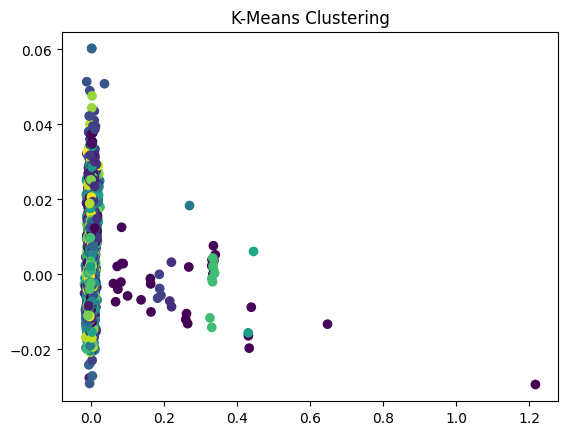

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA to your data
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X)  # X contains your sentence vectors

# Plot the clusters
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=df['cluster'], cmap='viridis')
plt.title('K-Means Clustering')
plt.show()

In [60]:
new_data = ["A new sentence to classify", "mental health trauma"]
new_vectors = [get_query_vector(sentence) for sentence in new_data]

# Predict cluster labels for new data
new_labels = kmeans.predict(new_vectors)
print("Cluster labels for new data:", new_labels)

Cluster labels for new data: [1181   15]


In [61]:
df[df['cluster'] == 1181]

,dt,institutional_affiliation,metric_id,personal_account_id,search_type,query_string,requestid,auth_sessionid,query_vector,cluster
1315,2023-08-20,True,Searches_Platform_d2fb01c9-9804-48eb-8c36-5b38...,NaN,basic_search,new years,fastly-default:0ddb92da82da10bd0eaa92bc03f9e2c4,e468e416d149482f9b76cf85980f728e,"[-0.009316137, 0.0102564655, 0.004382555, 0.00...",1181


In [62]:
df[df['cluster'] == 15]

,dt,institutional_affiliation,metric_id,personal_account_id,search_type,query_string,requestid,auth_sessionid,query_vector,cluster
266,2023-08-09,True,Searches_Platform_579504e7-6581-4b91-9691-305a...,NaN,advanced_search,mental health service school,fastly-default:02d07630d8f09add577d0e18132f1c3f,7e9c6bd641bb495a8354d395f8727e16,"[-0.002842872, 0.0053431513, -0.0048070694, -0...",15
363,2023-08-24,False,Searches_Platform_0aa5c7ec-2b2e-4556-9d82-8b5d...,e01b561f-fc62-4715-8883-41b9becabc72,basic_search,mental health murders,fastly-default:03abc07861fe5dbb6fadad6efbdf9174,49c91e111468483ba05fb7fcb4da63ab,"[0.0018393056, 0.0036343264, -0.005306639, 0.0...",15
865,2023-08-21,False,Searches_Platform_270ef0e8-53cb-4b48-a75b-bfc5...,NaN,basic_search,imposter syndrome mental health,fastly-default:091149174dcdc2ca35adf7614d566d15,c0d36378562d446180cbde7f217a2ebf,"[0.00089819985, 0.0033494404, -0.0024326209, 0...",15
915,2023-08-07,True,Searches_Platform_ce267aa2-5dc8-4d3d-bdd9-b562...,NaN,basic_search,international students australia mental health,fastly-default:09995f863fe58155738c883a61e60f55,73e53d7f3dd5421593c767414a3e35f3,"[-0.00012676325, -0.000104291736, -0.001995783...",15
1089,2023-08-16,True,Searches_Platform_40651f52-b341-4d07-8837-4900...,NaN,basic_search,briefing cuban mental health,fastly-default:0b52ba8faf35537eedbb265122301d86,2f498d9c3c4b431bb1fbfabd3a818d23,"[-0.0006324791, -0.002226621, 0.001300888, 0.0...",15
1168,2023-08-20,False,Searches_Platform_998c1551-281f-4f69-b543-5202...,NaN,basic_search,mental health social media,fastly-default:0c3cdd398201bb39cab87465e93d79b4,9458325b6660447fb6353102badcd971,"[-0.0013220136, 0.00079038425, -0.002107187, -...",15
1740,2023-08-01,False,Searches_Platform_34a03c43-68e0-4d4d-99da-b051...,11250839-e981-4580-9def-542a6e5f59d4,basic_search,moral code mental health individualism,fastly-default:12a2521bc96e510c1b2887bf184b0f55,42ad6141bad74c6ab658c77796cefb74,"[-0.0021393723, 0.000968648, 0.00041745938, -0...",15
2197,2023-08-15,True,Searches_Platform_e407e447-e5a7-4ab7-9594-7885...,NaN,basic_search,impact capitalism mental health,fastly-default:178a0e18ac8b89ab184eaf1b072feb5f,4c1ffa4a62c64fa3871c37b7ec9f5fe7,"[-0.00038537034, 0.0013569677, -0.002654443, 0...",15
3623,2023-08-25,True,Searches_Platform_c6c63b43-0b7b-49a5-8fbb-a81d...,NaN,basic_search,mental health lgbtqai,fastly-default:26fabe189649959a2e520461f0648ab2,78d73aa38568479ea85acb21390d0308,"[0.002662169, -0.0022787321, -0.00095037324, 0...",15
4000,2023-08-30,False,Searches_Platform_5f82ef9b-6128-48ae-8e8a-7921...,NaN,basic_search,mental health suicide,fastly-default:2ae1c7cd79d2b02f83d2369cedc3e4df,76fa563734724fdbb1100b562d10b7a7,"[-0.0026769035, 0.0001654725, -0.005664566, -0...",15


In [52]:
#Function for finding similar queries from entered sentence.
def find_similar_queries(new_query, df, model, kmeans):
    new_query_vector = get_query_vector(new_query)
    if new_query_vector is not None:
        cluster = kmeans.predict([new_query_vector])[0]
        cluster_queries = df[df['cluster'] == cluster]

        # Calculate distances between the new query and all queries in the same cluster
        distances = cdist([new_query_vector], cluster_queries['query_vector'].values.tolist(), 'cosine')[0]

        # Sort by similarity (lower distance is more similar)
        cluster_queries['similarity'] = 1 - distances
        cluster_queries = cluster_queries.sort_values(by='similarity', ascending=False)

        return cluster_queries['query'].values


#Practice Attempt
similar_queries = find_similar_queries("Fall of Roman Empire", df, model, kmeans)
print(similar_queries)

None
